In [33]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import copy


from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
19,12July_gpt2_10dim_12layer_256_RL,linear_regression,Transformer,,-1,-1,10,12,8,12July_gpt2_10dim_12layer_256_RL
21,12July_mlp_10dim_10layer_1024_RL,linear_regression,12July_mlp_10dim_10layer_1024_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_1024_RL
24,12July_mlp_10dim_10layer_512_RL,linear_regression,12July_mlp_10dim_10layer_512_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_512_RL
20,12July_mlp_10dim_22layer_1024_RL,linear_regression,12July_mlp_10dim_22layer_1024_RL,,-1,-1,10,22,8,12July_mlp_10dim_22layer_1024_RL
22,12July_mlp_10dim_5layer_1024_RL,linear_regression,12July_mlp_10dim_5layer_1024_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_1024_RL
23,12July_mlp_10dim_5layer_512_RL,linear_regression,12July_mlp_10dim_5layer_512_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_512_RL
26,24July_lstm_10dim_1layer_256_RL,linear_regression,24July_lstm_10dim_1layer_256_RL,,-1,-1,10,1,8,24July_lstm_10dim_1layer_256_RL
28,24July_lstm_10dim_5layer_256_RL,linear_regression,24July_lstm_10dim_5layer_256_RL,,-1,-1,10,5,8,24July_lstm_10dim_5layer_256_RL
25,24July_lstm_20dim_1layer_256_RL,linear_regression,24July_lstm_20dim_1layer_256_RL,,-1,-1,20,1,8,24July_lstm_20dim_1layer_256_RL
29,24July_lstm_20dim_5layer_256_RL,linear_regression,24July_lstm_20dim_5layer_256_RL,,-1,-1,20,5,8,24July_lstm_20dim_5layer_256_RL


linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<00:00, 109990.49it/s]


6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 314572.80it/s]

6Aug_lstm_20dim_8layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_8layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 325982.18it/s]


6Aug_lstm_20dim_7layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_7layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 343795.41it/s]


6Aug_lstm_20dim_6layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_6layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 343795.41it/s]


6Aug_lstm_20dim_5layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_5layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 343795.41it/s]


7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1 7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 271183.45it/s]


dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])
{'half_subspace': {'Transformer': {'mean': [0.9632429122924805, 0.9123161315917969, 0.7510465145111084, 0.6924034118652344, 0.6116585731506348, 0.4950979232788086, 0.39366726875305175, 0.31080701351165774, 0.20295586585998535, 0.1035406231880188, 0.03663731813430786, 0.011795975267887115, 0.005011618882417679, 0.003079252317547798, 0.0027918219566345215, 0.002493770234286785, 0.0021976608783006667, 0.002169094420969486, 0.0019014213234186173, 0.0015295283868908883, 0.0013808086514472961, 0.0011476188898086547, 0.0011712506413459778, 0.001076708547770977, 0.0009131195954978466, 0.0008459294214844704, 0.0006800353527069092, 0.0005611887201666832, 0.0005421477369964122, 0.0004785127006471157, 0.00043568005785346033, 0.0004106187727302313, 0.000

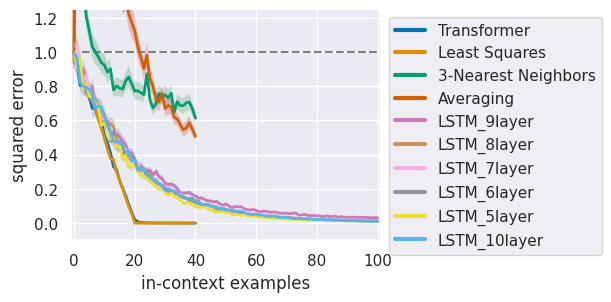

In [35]:
task = "linear_regression"
base_id = "pretrained"
expt_ids = {
    "LSTM_9layer": "6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1",
    "LSTM_8layer": "6Aug_lstm_20dim_8layer_256_lr1e-4_dropout0.1",
    "LSTM_7layer": "6Aug_lstm_20dim_7layer_256_lr1e-4_dropout0.1",
    "LSTM_6layer": "6Aug_lstm_20dim_6layer_256_lr1e-4_dropout0.1",
    "LSTM_5layer": "6Aug_lstm_20dim_5layer_256_lr1e-4_dropout0.1",
    "LSTM_10layer": "7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1",
}
models = ["Transformer", "Least Squares", "3-Nearest Neighbors", "Averaging"]
for key in expt_ids.keys(): 
   models.append(key)

base_path = os.path.join(run_dir, task, base_id)
expt_paths = {key: os.path.join(run_dir, task, expt_id) for key, expt_id in expt_ids.items()}

def valid_row(r, run_id):
    return r.task == task and r.run_id == run_id

def keep_before_underscore(s):
    if "_" in s:
        return s.split("_")[0]
    return s

metrics_base = collect_results(run_dir, df, valid_row=lambda r: valid_row(r, base_id))
metrics_expts = {key: collect_results(run_dir, df, valid_row=lambda r: valid_row(r, expt_id)) for key, expt_id in expt_ids.items()}

# _, conf = get_model_from_run(base_path, only_conf=True)
# n_dims = conf.model.n_dims

metrics = copy.deepcopy(metrics_base)

for key in metrics.keys():
    for expt_key, expt_metrics in metrics_expts.items():
        metrics[key][expt_key] = expt_metrics[key][keep_before_underscore(expt_key)]
print(metrics.keys())
print(metrics)

basic_plot(metrics["standard"], models=models)
plt.show()


linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<00:00, 188366.95it/s]


7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1 7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 199096.71it/s]


7Aug_lstm_20dim_5layer_512_lr0.0001_dropout0 7Aug_lstm_20dim_5layer_512_lr0.0001_dropout0


100%|██████████| 15/15 [00:00<00:00, 182891.16it/s]


dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])
{'half_subspace': {'Transformer': {'mean': [0.9632429122924805, 0.9123161315917969, 0.7510465145111084, 0.6924034118652344, 0.6116585731506348, 0.4950979232788086, 0.39366726875305175, 0.31080701351165774, 0.20295586585998535, 0.1035406231880188, 0.03663731813430786, 0.011795975267887115, 0.005011618882417679, 0.003079252317547798, 0.0027918219566345215, 0.002493770234286785, 0.0021976608783006667, 0.002169094420969486, 0.0019014213234186173, 0.0015295283868908883, 0.0013808086514472961, 0.0011476188898086547, 0.0011712506413459778, 0.001076708547770977, 0.0009131195954978466, 0.0008459294214844704, 0.0006800353527069092, 0.0005611887201666832, 0.0005421477369964122, 0.0004785127006471157, 0.00043568005785346033, 0.0004106187727302313, 0.000

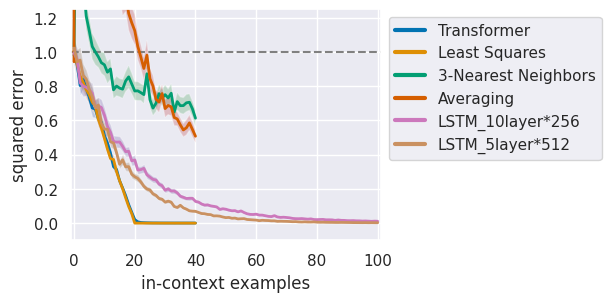

In [37]:
task = "linear_regression"
base_id = "pretrained"
expt_ids = {

    "LSTM_10layer*256": "7Aug_lstm_20dim_10layer_256_lr0.0001_dropout0.1",
    "LSTM_5layer*512": "7Aug_lstm_20dim_5layer_512_lr0.0001_dropout0",
}
models = ["Transformer", "Least Squares", "3-Nearest Neighbors", "Averaging"]
for key in expt_ids.keys(): 
   models.append(key)

base_path = os.path.join(run_dir, task, base_id)
expt_paths = {key: os.path.join(run_dir, task, expt_id) for key, expt_id in expt_ids.items()}

def valid_row(r, run_id):
    return r.task == task and r.run_id == run_id

def keep_before_underscore(s):
    if "_" in s:
        return s.split("_")[0]
    return s

metrics_base = collect_results(run_dir, df, valid_row=lambda r: valid_row(r, base_id))
metrics_expts = {key: collect_results(run_dir, df, valid_row=lambda r: valid_row(r, expt_id)) for key, expt_id in expt_ids.items()}

# _, conf = get_model_from_run(base_path, only_conf=True)
# n_dims = conf.model.n_dims

metrics = copy.deepcopy(metrics_base)

for key in metrics.keys():
    for expt_key, expt_metrics in metrics_expts.items():
        metrics[key][expt_key] = expt_metrics[key][keep_before_underscore(expt_key)]
print(metrics.keys())
print(metrics)

basic_plot(metrics["standard"], models=models)
plt.show()


In [ ]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [ ]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [ ]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [ ]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [ ]:
with torch.no_grad():

    pred = model(xs, ys)

In [ ]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

In [ ]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.